# Double-check tweet language with TextCat

Source: http://www.let.rug.nl/~vannoord/TextCat/

In [2]:
import os
import pandas as pd
import pipes
import re
import tempfile
from nltk.classify import textcat
from IPython.display import clear_output
from langdetect import detect,DetectorFactory
import langid

DetectorFactory.seed = 0

In [9]:
DATADIR = "/home/erikt/projects/puregome/data/text/"
DATADIRTEXTCAT = "/home/erikt/projects/puregome/data/textcat/"
IDSTR = "id_str"
TEXT = "text"
TEXTCATDIR = "/home/erikt/software/textcat/"
TEXTCAT = "text_cat"
PERL = "/usr/bin/perl"
TEXTUNKNOWN = "I don't know; Perhaps this is a language I haven't seen before?"
UNKNOWN = "unknown"
OR = " or "
DUTCH = "dutch"
LANG = "lang"
OTHER = "other"
DUTCHTEXTCAT = "nld"

In [4]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

In [5]:
def createPipe(command):
    pipe  = pipes.Template()
    pipe.append(command,"--")
    return(pipe)

def writeAllPipeInput(pipe,text):
    tmpFile = tempfile.NamedTemporaryFile(delete=False)
    f = pipe.open(tmpFile.name,"w")
    f.write(text)
    f.close()
    return(tmpFile.name)

def readPipeOutput(tmpFileName):
    tmpFile = open(tmpFileName,"r")
    textOut = ""
    for line in tmpFile: textOut += line
    tmpFile.close()
    os.unlink(tmpFileName)
    return(textOut)

def textcatString2List(text):
    if text == TEXTUNKNOWN: return([UNKNOWN])
    else: return(text.split(OR))

def textcatLocal(textIn):
    pipe = createPipe(PERL+" "+TEXTCATDIR+TEXTCAT)
    tmpFileName = writeAllPipeInput(pipe,textIn)
    textOut = readPipeOutput(tmpFileName)
    return(textcatString2List(textOut.strip()))

## Language detection with TextCat

In [20]:
FILEPATTERN = "20200[6]..-07"
MAXTWEETS = 200

tc = textcat.TextCat()
inFiles = sorted(os.listdir(DATADIR))
outFiles = sorted(os.listdir(DATADIRTEXTCAT))
for inFileName in inFiles:
    if re.search(FILEPATTERN,inFileName): # and not inFileName in outFiles:
        df = pd.read_csv(DATADIR+inFileName,index_col=IDSTR)[:MAXTWEETS]
        dutchCount = 0
        otherCount = 0
        dutchPercentage = 0
        lang = []
        seen = {}
        for i in range(0,len(df)):
            text = re.sub(r"\\n"," ",df.iloc[i][TEXT])
            if text in seen: textcatOut = seen[text]
            else:
                textcatOut = textcatLocal(text.lower())
                seen[text] = textcatOut
            if DUTCH in textcatOut: 
                lang.append(DUTCH)
                dutchCount += 1
            elif UNKNOWN in textcatOut: 
                lang.append(UNKNOWN)
            else: 
                lang.append(textcatOut[0])
                otherCount += 1
            if dutchCount > 0: 
                dutchPercentage = round(dutchCount/(dutchCount+otherCount),3)
        df[LANG] = lang
        df.to_csv(DATADIRTEXTCAT+inFileName,compression="gzip")
        print("{0} {1} {2:0.3f} {3}".format(i+1,len(df),dutchPercentage,inFileName))

200 200 0.980 20200601-07.out.gz
200 200 0.956 20200602-07.out.gz
200 200 0.986 20200603-07.out.gz
200 200 0.960 20200604-07.out.gz
200 200 0.969 20200605-07.out.gz
200 200 0.979 20200606-07.out.gz
200 200 0.969 20200607-07.out.gz
200 200 0.954 20200608-07.out.gz
200 200 0.968 20200609-07.out.gz
200 200 0.922 20200610-07.out.gz
200 200 0.944 20200611-07.out.gz
200 200 0.908 20200612-07.out.gz
200 200 0.911 20200613-07.out.gz
200 200 0.902 20200614-07.out.gz
200 200 0.866 20200615-07.out.gz
200 200 0.901 20200616-07.out.gz
200 200 0.889 20200617-07.out.gz
200 200 0.854 20200618-07.out.gz
200 200 0.914 20200619-07.out.gz
200 200 0.873 20200620-07.out.gz
200 200 0.808 20200621-07.out.gz
200 200 0.844 20200622-07.out.gz
200 200 0.897 20200623-07.out.gz
200 200 0.894 20200624-07.out.gz
200 200 0.902 20200625-07.out.gz
200 200 0.928 20200626-07.out.gz
200 200 0.926 20200627-07.out.gz
200 200 0.941 20200628-07.out.gz
200 200 0.915 20200629-07.out.gz
200 200 0.858 20200630-07.out.gz


## Language detection with langdetect

In [ ]:
FILEPATTERN = "202006..-05"
MAXTWEETS = 200

inFiles = sorted(os.listdir(DATADIR))
outFiles = sorted(os.listdir(DATADIRTEXTCAT))
for inFileName in inFiles:
    if re.search(FILEPATTERN,inFileName) and not inFileName in outFiles:
        df = pd.read_csv(DATADIR+inFileName,index_col=IDSTR)[:MAXTWEETS]
        dutchCount = 0
        otherCount = 0
        dutchPercentage = 0
        lang = []
        for i in range(0,len(df)):
            text = re.sub(r"\\n"," ",df.iloc[i][TEXT])
            try:
                textcatOut = detect(text.lower())
            except: continue
            if textcatOut == "nl":
                lang.append(DUTCH)
                dutchCount += 1
            else: 
                lang.append(textcatOut)
                otherCount += 1
            if dutchCount > 0: 
                dutchPercentage = round(dutchCount/(dutchCount+otherCount),3)
        df[LANG] = lang
        df.to_csv(DATADIRTEXTCAT+inFileName,compression="gzip")
        print("{0} {1} {2:0.3f} {3}".format(i+1,len(df),dutchPercentage,inFileName))

## Language detection with langid

In [11]:
FILEPATTERN = "2020071[01]"
MAXTWEETS = 1000

inFiles = sorted(os.listdir(DATADIR))
outFiles = sorted(os.listdir(DATADIRTEXTCAT))
results = {}
for inFileName in inFiles:
    if re.search(FILEPATTERN,inFileName):# and not inFileName in outFiles:
        df = pd.read_csv(DATADIR+inFileName,index_col=IDSTR)[:MAXTWEETS]
        dutchCount = 0
        otherCount = 0
        dutchPercentage = 0
        lang = []
        for i in range(0,len(df)):
            text = re.sub(r"\\n"," ",df.iloc[i][TEXT])
            try:
                textcatOut = list(langid.classify(text.lower()))[0]
            except: continue
            if textcatOut == "nl":
                lang.append(DUTCH)
                dutchCount += 1
            else: 
                lang.append(textcatOut)
                otherCount += 1
            if dutchCount > 0: 
                dutchPercentage = round(dutchCount/(dutchCount+otherCount),3)
        df[LANG] = lang
        df.to_csv(DATADIRTEXTCAT+inFileName,compression="gzip")
        date = inFileName[0:11]
        results[date] = dutchPercentage
        print("{0} {1} {2:0.3f} {3}".format(i+1,len(df),dutchPercentage,inFileName))

1000 1000 0.710 20200710-00.out.gz
1000 1000 0.608 20200710-01.out.gz
1000 1000 0.473 20200710-02.out.gz
1000 1000 0.409 20200710-03.out.gz
1000 1000 0.325 20200710-04.out.gz
1000 1000 0.259 20200710-05.out.gz
1000 1000 0.586 20200710-06.out.gz
1000 1000 0.603 20200710-07.out.gz
1000 1000 0.755 20200710-08.out.gz
1000 1000 0.794 20200710-09.out.gz
1000 1000 0.833 20200710-10.out.gz
1000 1000 0.787 20200710-11.out.gz
1000 1000 0.813 20200710-12.out.gz
1000 1000 0.795 20200710-13.out.gz
1000 1000 0.765 20200710-14.out.gz
1000 1000 0.786 20200710-15.out.gz
1000 1000 0.719 20200710-16.out.gz
1000 1000 0.752 20200710-17.out.gz
1000 1000 0.708 20200710-18.out.gz
1000 1000 0.731 20200710-19.out.gz
1000 1000 0.762 20200710-20.out.gz
1000 1000 0.761 20200710-21.out.gz
1000 1000 0.770 20200710-22.out.gz
1000 1000 0.752 20200710-23.out.gz
1000 1000 0.720 20200711-00.out.gz
1000 1000 0.665 20200711-01.out.gz
1000 1000 0.836 20200711-02.out.gz
1000 1000 0.784 20200711-03.out.gz
1000 1000 0.779 2020

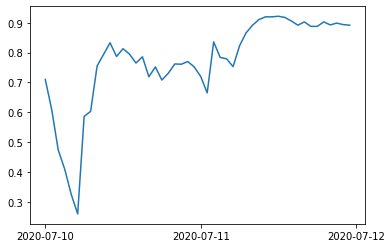

In [15]:
import datetime
import matplotlib.pyplot as plt

DATEFORMAT = "%Y%m%d-%H"

x = [datetime.datetime.strptime(k,DATEFORMAT) for k in results.keys()]
y = list(results.values())
plt.plot_date(x,y,fmt="-")
plt.xticks([datetime.datetime.strptime(d,DATEFORMAT) for d in "20200710-00 20200711-00 20200712-00".split()])
plt.show()